Team Members

*   Libin Kutty - Group 2
*   Ritu Gahir - Group 3
*   Viju Sudhi - Group 10

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, convolution_layer=False):
    super(Encoder, self).__init__()
    self.conv = convolution_layer
    if convolution_layer:
      
      self.input_layer = tf.keras.layers.InputLayer(input_shape=(28, 28, 1))

      self.hidden_layer1 = tf.keras.layers.Conv2D(filters=32, 
                                    kernel_size=3, 
                                    #strides=(2, 2), 
                                    activation='relu')

      self.hidden_layer2 = tf.keras.layers.Conv2D(filters=64, 
                                    kernel_size=3, 
                                    #strides=(2, 2), 
                                    activation='relu')

      self.flatten_layer = tf.keras.layers.Flatten()
        
      self.output_layer = tf.keras.layers.Dense(units=intermediate_dim + intermediate_dim)

    else:
      
      self.hidden_layer1 = tf.keras.layers.Dense(
        units=256,
        activation=tf.nn.leaky_relu,
        kernel_initializer='he_uniform'
      )

      self.hidden_layer2 = tf.keras.layers.Dense(
        units=128,
        activation=tf.nn.leaky_relu,
        kernel_initializer='he_uniform'
      )
      self.output_layer = tf.keras.layers.Dense(
        units=64, #intermediate_dim - 32,
        activation=tf.nn.leaky_relu,
        kernel_initializer='he_uniform'
      )
    
  def call(self, input_features):
    if self.conv:
      input_features = self.input_layer(input_features)
    hidden_op = self.hidden_layer1(input_features)
    activation = self.hidden_layer2(hidden_op)
    if self.conv:
      activation = self.flatten_layer(activation)
    return self.output_layer(activation)

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, original_dim, convolution_layer=False):
    super(Decoder, self).__init__()
    self.conv = convolution_layer
    if convolution_layer:

      self.input_layer = tf.keras.layers.InputLayer(input_shape=(intermediate_dim,))

      self.hidden_layer1 = tf.keras.layers.Dense(units=28*28*1,
                                                 activation=tf.nn.relu)

      self.input_reshape = tf.keras.layers.Reshape(target_shape=(28, 28, 1))

      self.hidden_layer2 = tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
#              strides=(2, 2),
              padding="SAME",
              activation='relu')

      self.hidden_layer3 = tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
#              strides=(2, 2),
              padding="SAME",
              activation='relu')

      self.output_layer = tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, 
#              strides=(1, 1),
               padding="SAME")

    else:

      self.hidden_layer1 = tf.keras.layers.Dense(
        units=64,
        activation=tf.nn.leaky_relu,
        kernel_initializer='he_uniform'
      )

      self.hidden_layer2 = tf.keras.layers.Dense(
        units=128,
        activation=tf.nn.leaky_relu,
        kernel_initializer='he_uniform'
      )

      self.hidden_layer3 = tf.keras.layers.Dense(
        units=256,
        activation=tf.nn.leaky_relu,
        kernel_initializer='he_uniform'
      )

      self.output_layer = tf.keras.layers.Dense(
        units=original_dim,
        activation=tf.nn.sigmoid
      )
  
  def call(self, code):
    #if self.conv:
    #  code = self.input_layer(code)
    h1_op = self.hidden_layer1(code)
    if self.conv:
      h1_op = self.input_reshape(h1_op)
    h2_op = self.hidden_layer2(h1_op)
    activation = self.hidden_layer3(h2_op)
    return self.output_layer(activation)

In [0]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim, convolution_layer = False):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(intermediate_dim=intermediate_dim,convolution_layer=convolution_layer)
    self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim, convolution_layer=convolution_layer)

  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

In [0]:
def loss(model, original):
  #reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
  ae_loss = tf.losses.BinaryCrossentropy(from_logits=True)
  reconstruction_error = ae_loss(original, model(original))
  return reconstruction_error

In [0]:
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model, original), model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)

In [87]:
batch_size = 128
epochs = 10
conv=False

autoencoder = Autoencoder(intermediate_dim=32, original_dim=784, convolution_layer=conv) #784
opt = tf.optimizers.Adam(learning_rate=0.01)

(training_features, _), (test_features, _) = tf.keras.datasets.fashion_mnist.load_data()  #cifar10.load_data()

training_features = training_features / np.max(training_features)

training_features = training_features.reshape(training_features.shape[0],
                                          training_features.shape[1] * training_features.shape[2])
training_features = training_features.astype('float32')

test_features = test_features / np.max(test_features)

test_features = test_features.reshape(test_features.shape[0],
                                     test_features.shape[1] * test_features.shape[2])
test_features = test_features.astype('float32')

training_dataset = tf.data.Dataset.from_tensor_slices(training_features)
training_dataset = training_dataset.shuffle(training_features.shape[0])
training_dataset = training_dataset.batch(batch_size)

#training_dataset = training_dataset.prefetch(batch_size * 4)

for epoch in range(epochs):
  for step, batch_features in enumerate(training_dataset):
    train(loss, autoencoder, opt, batch_features)
    loss_values = loss(autoencoder, batch_features)

  #if not step % 10:
  print(epoch, loss_values)


0 tf.Tensor(0.69396925, shape=(), dtype=float32)
1 tf.Tensor(0.6937936, shape=(), dtype=float32)
2 tf.Tensor(0.69325334, shape=(), dtype=float32)
3 tf.Tensor(0.69456106, shape=(), dtype=float32)
4 tf.Tensor(0.69347715, shape=(), dtype=float32)
5 tf.Tensor(0.6942377, shape=(), dtype=float32)
6 tf.Tensor(0.693793, shape=(), dtype=float32)
7 tf.Tensor(0.6937239, shape=(), dtype=float32)
8 tf.Tensor(0.69439155, shape=(), dtype=float32)
9 tf.Tensor(0.6930728, shape=(), dtype=float32)


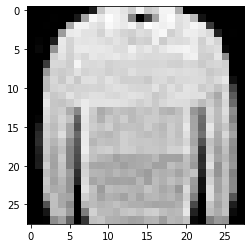

In [88]:
autoencoder_test = autoencoder(input_features=test_features)

original_img = tf.reshape(test_features, (test_features.shape[0], 28, 28))#28, 28))

reconstructed_img = tf.reshape(autoencoder_test, (autoencoder_test.shape[0], 28, 28))# 28, 28))

plt.imshow(original_img[20], cmap="Greys_r")

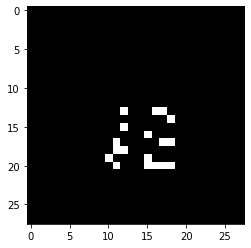

In [89]:
plt.imshow(reconstructed_img[20], cmap="Greys_r")

In [0]:
batch_size = 128
epochs = 10
conv=True

autoencoder = Autoencoder(intermediate_dim=32, original_dim=784, convolution_layer=conv) #784
opt = tf.optimizers.Adam(learning_rate=0.1)

(training_features, _), (test_features, _) = tf.keras.datasets.fashion_mnist.load_data()

training_features = training_features / np.max(training_features)

training_features = training_features.reshape(training_features.shape[0],
                                          training_features.shape[1], training_features.shape[2], 1)
training_features = training_features.astype('float32')

test_features = test_features / np.max(test_features)

test_features = test_features.reshape(test_features.shape[0],
                                     test_features.shape[1], test_features.shape[2], 1)
test_features = test_features.astype('float32')

training_dataset = tf.data.Dataset.from_tensor_slices(training_features)
training_dataset = training_dataset.batch(batch_size)
training_dataset = training_dataset.shuffle(training_features.shape[0])
#training_dataset = training_dataset.prefetch(batch_size * 4)

for epoch in range(epochs):
  for step, batch_features in enumerate(training_dataset):
    train(loss, autoencoder, opt, batch_features)
    loss_values = loss(autoencoder, batch_features)

  #if not step % 10:
  print(epoch, loss_values)

0 tf.Tensor(0.6031861, shape=(), dtype=float32)
1 tf.Tensor(0.59396976, shape=(), dtype=float32)
2 tf.Tensor(0.59863985, shape=(), dtype=float32)
3 tf.Tensor(0.6170688, shape=(), dtype=float32)
4 tf.Tensor(0.5788452, shape=(), dtype=float32)


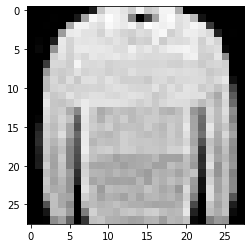

In [60]:
autoencoder_test = autoencoder(input_features=test_features)

original_img = tf.reshape(test_features, (test_features.shape[0], 28, 28))

reconstructed_img = tf.reshape(autoencoder_test, (autoencoder_test.shape[0], 28, 28))

plt.imshow(original_img[20], cmap="Greys_r")

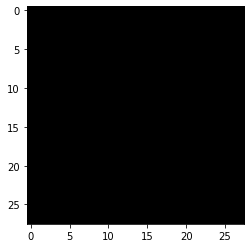

In [61]:
plt.imshow(reconstructed_img[20], cmap="Greys_r")